In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import copy
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   

os.environ["CUDA_VISIBLE_DEVICES"]="2"

import matplotlib.pyplot as plt
import torch.optim as optim


In [2]:
torch.manual_seed(0)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
CIFAR_SGD_trainloader = torch.utils.data.DataLoader(trainset, batch_size=500,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=8)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #print(npimg)
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(np.transpose(npimg))#, (1, 2, 0)))
    plt.show()

In [8]:
'''for i in range(5):
    tmp=trainset[i]
    fig=plt.figure
    plt.imshow(np.transpose(tmp[0],(1,2,0)))
    plt.show()
    print(classes[tmp[1]])'''

'for i in range(5):\n    tmp=trainset[i]\n    fig=plt.figure\n    plt.imshow(np.transpose(tmp[0],(1,2,0)))\n    plt.show()\n    print(classes[tmp[1]])'

In [9]:
'''# get some random training images
dataiter = iter(CIFAR_SGD_trainloader)
images, labels = dataiter.next()
print(images.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# print size of single image
print(images[1].shape)'''

"# get some random training images\ndataiter = iter(CIFAR_SGD_trainloader)\nimages, labels = dataiter.next()\nprint(images.shape)\n# show images\nimshow(torchvision.utils.make_grid(images))\n# print labels\nprint(' '.join('%5s' % classes[labels[j]] for j in range(4)))\n# print size of single image\nprint(images[1].shape)"

In [10]:
class DatasetSplit(Dataset):
    """An abstract Dataset class wrapped around Pytorch Dataset class.
    """

    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return torch.tensor(image), torch.tensor(label)

In [11]:
def cifar_iid(dataset, num_users):
    """
    Sample I.I.D. client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    #num_items=8
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items, replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users

In [12]:
'''cifar_iid_dataset=cifar_iid(trainset,2)
print(cifar_iid_dataset)'''

'cifar_iid_dataset=cifar_iid(trainset,2)\nprint(cifar_iid_dataset)'

In [13]:
'''num_clients=2
num_items=8

for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_iid_dataset[x])
    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)
    dataiter=iter(CIFAR_client_trainloader)
    for i in range(int(num_items/4)):
        images,labels=dataiter.next()
        print(images.shape)
        #print(trainset[index_list[i]])
        #print(image)
        fig=plt.figure
        imshow(torchvision.utils.make_grid(images))
        print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
        #print(classes[trainset[index_list[i]][1]])'''

'num_clients=2\nnum_items=8\n\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_iid_dataset[x])\n    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)\n    dataiter=iter(CIFAR_client_trainloader)\n    for i in range(int(num_items/4)):\n        images,labels=dataiter.next()\n        print(images.shape)\n        #print(trainset[index_list[i]])\n        #print(image)\n        fig=plt.figure\n        imshow(torchvision.utils.make_grid(images))\n        print(\' \'.join(\'%5s\' % classes[labels[j]] for j in range(4)))\n        #print(classes[trainset[index_list[i]][1]])'

In [14]:
'''num_clients=2
num_items=5

for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_iid_dataset[x])
    for i in range(num_items):
        image=trainset[index_list[i]][0]
        #print(trainset[index_list[i]])
        #print(image)
        fig=plt.figure
        plt.imshow(np.transpose(image,(1,2,0)))
        plt.show()
        print(classes[trainset[index_list[i]][1]])'''

'num_clients=2\nnum_items=5\n\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_iid_dataset[x])\n    for i in range(num_items):\n        image=trainset[index_list[i]][0]\n        #print(trainset[index_list[i]])\n        #print(image)\n        fig=plt.figure\n        plt.imshow(np.transpose(image,(1,2,0)))\n        plt.show()\n        print(classes[trainset[index_list[i]][1]])'

In [15]:
def cifar_noniid(dataset, num_users,class_per_user=1):
    """
    Sample non-I.I.D client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return:
    """
    #num_shards, num_imgs = 200, 250
    #num_shards, num_imgs = 200, 250
    class_per_user=class_per_user
    num_shards=num_users*class_per_user
    num_imgs=int(len(dataset)/num_shards)
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([],dtype='int64') for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    # labels = dataset.train_labels.numpy()
    #labels = np.array(dataset.train_labels)

    labels=[]
    for element in dataset:
        labels.append(int(element[1]))
    #print(type(labels[0]))
    labels=np.array(labels)
    #labels=labels.astype('int64')
    # sort labels
    
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]

    # divide and assign
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, class_per_user, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
    return dict_users

In [16]:
'''cifar_noniid_dataset=cifar_noniid(trainset,2)
print(cifar_noniid_dataset)'''

'cifar_noniid_dataset=cifar_noniid(trainset,2)\nprint(cifar_noniid_dataset)'

In [17]:
'''num_clients=2
num_items=250*2

for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_noniid_dataset[x])
    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)
    dataiter=iter(CIFAR_client_trainloader)
    for i in range(int(num_items/4)):
        images,labels=dataiter.next()
        print(images.shape)
        #print(trainset[index_list[i]])
        #print(image)
        fig=plt.figure
        imshow(torchvision.utils.make_grid(images))
        print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
        #print(classes[trainset[index_list[i]][1]])'''

'num_clients=2\nnum_items=250*2\n\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_noniid_dataset[x])\n    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)\n    dataiter=iter(CIFAR_client_trainloader)\n    for i in range(int(num_items/4)):\n        images,labels=dataiter.next()\n        print(images.shape)\n        #print(trainset[index_list[i]])\n        #print(image)\n        fig=plt.figure\n        imshow(torchvision.utils.make_grid(images))\n        print(\' \'.join(\'%5s\' % classes[labels[j]] for j in range(4)))\n        #print(classes[trainset[index_list[i]][1]])'

In [18]:
'''num_clients=2
num_items=5
num_imgs=250
cifar_noniid_dataset=cifar_noniid(trainset, num_clients)
#print(cifar_noniid_dataset)
for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_noniid_dataset[x])
    #print(index_list)
    #print(index_list[0])
    #print(type(index_list[0]))
    for y in range(2):
        for i in range(num_items):
            image=trainset[index_list[i+num_imgs*y]][0]
            #print(image)
            fig=plt.figure
            plt.imshow(np.transpose(image,(1,2,0)))
            plt.show()
            print(classes[trainset[index_list[i+num_imgs*y]][1]])'''

'num_clients=2\nnum_items=5\nnum_imgs=250\ncifar_noniid_dataset=cifar_noniid(trainset, num_clients)\n#print(cifar_noniid_dataset)\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_noniid_dataset[x])\n    #print(index_list)\n    #print(index_list[0])\n    #print(type(index_list[0]))\n    for y in range(2):\n        for i in range(num_items):\n            image=trainset[index_list[i+num_imgs*y]][0]\n            #print(image)\n            fig=plt.figure\n            plt.imshow(np.transpose(image,(1,2,0)))\n            plt.show()\n            print(classes[trainset[index_list[i+num_imgs*y]][1]])'

In [19]:
def Quantize(input):
    result=torch.sign(input)
    return result

아직 이름만 signSGD이지 일반적인 SGD와 같을 때

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        #self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = (F.relu(self.conv3(x)))
        x = x.view(-1, 64*4*4)
        x = F.relu(self.fc1(x))
        x = (self.fc2(x))
        
        return x

In [21]:
def get_from_absmomentum(momentum,func):
    save=0
    if func==max:
        save=-float('inf')
    if func==min:
        save=float('inf')
    numel=0
    for el in momentum:
        el=abs(el)
        if func=='mean':
            save+=el.sum()
            numel+=el.numel()
        if func==max:
            save=save if save>el.max() else el.max()
        if func==min:
            save=save if save<el.min() else el.min()

    if func=='mean':
        save/=numel
    
    
    return save
    

signSGD Federated learning

In [22]:
def error_send(momentum,p_t,cut):
    boundary_low=cut*0.7
    boundary_high=cut*1.3
    abs_moment=abs(momentum)
    result=p_t*((abs_moment<boundary_low)|(abs_moment>boundary_high))
    return result
    

In [23]:
import torch
from torch.optim import Optimizer#, required


class signSGD(Optimizer):
    r"""Implements stochastic gradient descent (optionally with momentum).

    Nesterov momentum is based on the formula from
    `On the importance of initialization and momentum in deep learning`__.

    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)

    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()

    __ http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf

    .. note::
        The implementation of SGD with Momentum/Nesterov subtly differs from
        Sutskever et. al. and implementations in some other frameworks.

        Considering the specific case of Momentum, the update can be written as

        .. math::
            \begin{aligned}
                v_{t+1} & = \mu * v_{t} + g_{t+1}, \\
                p_{t+1} & = p_{t} - \text{lr} * v_{t+1},
            \end{aligned}

        where :math:`p`, :math:`g`, :math:`v` and :math:`\mu` denote the 
        parameters, gradient, velocity, and momentum respectively.

        This is in contrast to Sutskever et. al. and
        other frameworks which employ an update of the form

        .. math::
            \begin{aligned}
                v_{t+1} & = \mu * v_{t} + \text{lr} * g_{t+1}, \\
                p_{t+1} & = p_{t} - v_{t+1}.
            \end{aligned}

        The Nesterov version is analogously modified.
    """

    def __init__(self, params, lr=-1, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False,error=[]):
        #if lr is not required and lr < 0.0:
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(signSGD, self).__init__(params, defaults)
        self.error=error
        self.num_of_step=0

    def __setstate__(self, state):
        super(signSGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self,On=True,cut=0.0007, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        #print(self.param_groups)
        gradient=[]
        first=1
        
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                
                if weight_decay != 0:
                    d_p = d_p.add(p, alpha=weight_decay)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        if On==True:
                            d_p=error_send(momentum=buf,p_t=d_p,cut=cut)
                        
                            
                        buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    '''if nesterov:
                        d_p = d_p.add(buf, alpha=momentum)
                    else:
                        d_p = buf'''

                p.add_(d_p, alpha=-group['lr'])

        return loss
    @torch.no_grad()
    def get_momentum(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        #print(self.param_groups)
        momentum=[]
        for group in self.param_groups:

            

            for p in group['params']:
                param_state = self.state[p]
                momentum.append(param_state['momentum_buffer'])
        return (momentum)
    
    @torch.no_grad()
    def get_quantized_momentum(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        #print(self.param_groups)
        momentum=[]
        for group in self.param_groups:

            

            for p in group['params']:
                param_state = self.state[p]
                momentum.append(torch.sign(param_state['momentum_buffer']))
        return (momentum)

In [24]:
def get_quantizationLoss(gradient,lr):
    total=0
    for layer_grad in gradient:
        
        quantized_layer_grad=torch.sign(layer_grad)*lr
        layer_quantize_loss=(abs(layer_grad-quantized_layer_grad)).sum()
        total+=layer_quantize_loss
    return total
    

In [25]:
class LocalUpdate(object):
    def __init__(self,lr,local_epoch,device,batch_size, dataset=None, idxs=None):
        self.lr=lr
        self.local_epoch=local_epoch
        self.device=device
        self.loss_func = nn.CrossEntropyLoss()
        self.selected_clients = []
        self.ldr_train = DataLoader(DatasetSplit(dataset, idxs), batch_size=batch_size, shuffle=True)
        self.iterate=0
        self.error=[]
        self.cut_epoch=int(0.6*self.local_epoch)

    def train(self,net,On=True):
        net.train()
        # train and update
        optimizer=signSGD(net.parameters(), lr=0.1,error=self.error,momentum=1)
        #print(f"On:{On}")
        epoch_loss = []
        for iter in range(self.local_epoch):
            if iter<self.cut_epoch:
                this_on=False
                cut=self.lr
            if iter==self.cut_epoch:
                this_on=On
                this_momentum=optimizer.get_momentum()
                cut=get_from_absmomentum(this_momentum,'mean')
                
                
            batch_loss = []
            
            
            #print(this_on,cut)
            
            for batch_idx, (images, labels) in enumerate(self.ldr_train):
                images, labels = images.to(self.device), labels.to(self.device)
                net.zero_grad()
                log_probs = net(images)
                loss = self.loss_func(log_probs, labels)
                loss.backward()
                optimizer.step(On=this_on,cut=cut)
                batch_loss.append(loss.item())
            epoch_loss.append(sum(batch_loss)/len(batch_loss))
        momentum=optimizer.get_quantized_momentum()
        return momentum, sum(epoch_loss) / len(epoch_loss),cut

In [26]:
def list_add(a,b,c):
    result=[]
    for i in range(len(a)):
        result.append(a[i]+b[i]*c)
    return result

cifar10 FedAvg iid로 학습

In [27]:
device=torch.device('cuda')
FedAvg_model=Net().cuda()
criterion= nn.CrossEntropyLoss().to(device)
FedAvg_model.train()
epoch_loss = []

# Set optimizer for the local updates

optimizer = torch.optim.SGD(FedAvg_model.parameters(), lr=0.001,
                                momentum=0.9)
global_epoch=501

In [28]:
weight_saved=FedAvg_model.state_dict()

In [29]:
C=0.1
num_clients=100
#CIFAR_noniid_dataset=cifar_noniid(trainset, num_clients)
CIFAR_iid_dataset=cifar_iid(trainset, num_clients)
loss_train = []
acc_train=[]

맨 처음에 local gradient sign이 0인 경우가 있는 것 같다(진짜로 0이어서 그것의 sign도 0이 나오는 경우...)

In [30]:
#low boundary 안에 있는 녀석들만 update했을 때
learning_rate=0.0007
for epoch in range(global_epoch):

    #m=max(int(C*num_clients),1)
    m=5
    print(f"This is global {epoch} epoch")
    selected_user=np.random.choice(range(num_clients),m,replace=False)
    first=1
    local_setting=[]
    for repeat in range(10):
        local_gradient=[]
        local_loss=[]
        local_cut=[]
        
        for idx,user in enumerate(selected_user):
            #print(f"client :{idx}")
            if first==1:
                #local_setting.append(LocalUpdate(lr=0.0007,local_epoch=50,device=device,batch_size=40,dataset=trainset, idxs=CIFAR_iid_dataset[user]))
                local_setting.append(LocalUpdate(lr=learning_rate,local_epoch=5,device=device,batch_size=40,dataset=trainset, idxs=CIFAR_iid_dataset[user]))
                this_local_setting=local_setting[-1]
            else:
                this_local_setting=local_setting[idx]
            gradient,loss,cut=this_local_setting.train(net=copy.deepcopy(FedAvg_model).to(device),On=True)

            local_gradient.append(copy.deepcopy(gradient))
            #print(local_weight[0].keys())
            local_loss.append(copy.deepcopy(loss))
            local_cut.append(copy.deepcopy(cut))
        #print("Local_gradient")
        #print(local_gradient)
        first=0
        FedAvg_gradient=copy.deepcopy(local_gradient[0])
        for i in range(len(FedAvg_gradient)):
            FedAvg_gradient[i]*=local_cut[0]
        #print(local_gradient)
        #for key in FedAvg_weight.keys():
        for i in range(1,len(local_gradient)):
            FedAvg_gradient=list_add(FedAvg_gradient,local_gradient[i],local_cut[i])
            #print(i)
            #print(FedAvg_gradient[0])
        #print("FedAvg_gradient")
        #print(FedAvg_gradient)
        temp=FedAvg_model.state_dict()
        for idx,key in enumerate(temp.keys()):
            #print(key)
            #print(temp[key].size())
            #print(FedAvg_gradient[idx].size())
            #print(torch.sign(FedAvg_gradient[idx]))
            #print(torch.sign(FedAvg_gradient[idx])*learning_rate)
            temp[key]+=-learning_rate*torch.sign(FedAvg_gradient[idx])
            #print(temp[key])
        FedAvg_model.load_state_dict(temp)
    first=1
    loss_avg = sum(local_loss) / len(local_loss)
    print(' Average loss {:.3f}'.format( loss_avg))
    loss_train.append(loss_avg)
    if epoch%1==0:
        for j in range(1):
            FedAvg_model.eval()         
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = FedAvg_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %f %%' % (
                100 * correct / float(total)))
        acc_train.append(100 * correct / float(total))
 
    FedAvg_model.train()

This is global 0 epoch


/home/sonic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


 Average loss 1.961
Accuracy of the network on the 10000 test images: 23.750000 %
This is global 1 epoch
 Average loss 1.759
Accuracy of the network on the 10000 test images: 33.600000 %
This is global 2 epoch
 Average loss 1.575
Accuracy of the network on the 10000 test images: 39.110000 %
This is global 3 epoch
 Average loss 1.395
Accuracy of the network on the 10000 test images: 42.520000 %
This is global 4 epoch
 Average loss 1.329
Accuracy of the network on the 10000 test images: 45.420000 %
This is global 5 epoch
 Average loss 1.244
Accuracy of the network on the 10000 test images: 47.620000 %
This is global 6 epoch
 Average loss 1.166
Accuracy of the network on the 10000 test images: 49.390000 %
This is global 7 epoch
 Average loss 1.104
Accuracy of the network on the 10000 test images: 51.380000 %
This is global 8 epoch
 Average loss 0.946
Accuracy of the network on the 10000 test images: 51.800000 %
This is global 9 epoch
 Average loss 0.861
Accuracy of the network on the 1000

 Average loss 0.167
Accuracy of the network on the 10000 test images: 61.650000 %
This is global 79 epoch
 Average loss 0.118
Accuracy of the network on the 10000 test images: 61.530000 %
This is global 80 epoch
 Average loss 0.149
Accuracy of the network on the 10000 test images: 62.050000 %
This is global 81 epoch
 Average loss 0.171
Accuracy of the network on the 10000 test images: 61.920000 %
This is global 82 epoch
 Average loss 0.138
Accuracy of the network on the 10000 test images: 62.090000 %
This is global 83 epoch
 Average loss 0.133
Accuracy of the network on the 10000 test images: 62.010000 %
This is global 84 epoch
 Average loss 0.088
Accuracy of the network on the 10000 test images: 61.720000 %
This is global 85 epoch
 Average loss 0.167
Accuracy of the network on the 10000 test images: 61.840000 %
This is global 86 epoch
 Average loss 0.135
Accuracy of the network on the 10000 test images: 61.840000 %
This is global 87 epoch
 Average loss 0.131
Accuracy of the network on

 Average loss 0.036
Accuracy of the network on the 10000 test images: 62.980000 %
This is global 156 epoch
 Average loss 0.104
Accuracy of the network on the 10000 test images: 62.640000 %
This is global 157 epoch
 Average loss 0.058
Accuracy of the network on the 10000 test images: 62.640000 %
This is global 158 epoch
 Average loss 0.109
Accuracy of the network on the 10000 test images: 62.460000 %
This is global 159 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 63.520000 %
This is global 160 epoch
 Average loss 0.092
Accuracy of the network on the 10000 test images: 63.020000 %
This is global 161 epoch
 Average loss 0.021
Accuracy of the network on the 10000 test images: 63.290000 %
This is global 162 epoch
 Average loss 0.053
Accuracy of the network on the 10000 test images: 63.020000 %
This is global 163 epoch
 Average loss 0.077
Accuracy of the network on the 10000 test images: 62.820000 %
This is global 164 epoch
 Average loss 0.091
Accuracy of the n

 Average loss 0.011
Accuracy of the network on the 10000 test images: 63.120000 %
This is global 233 epoch
 Average loss 0.031
Accuracy of the network on the 10000 test images: 63.050000 %
This is global 234 epoch
 Average loss 0.005
Accuracy of the network on the 10000 test images: 63.350000 %
This is global 235 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 62.900000 %
This is global 236 epoch
 Average loss 0.033
Accuracy of the network on the 10000 test images: 62.570000 %
This is global 237 epoch
 Average loss 0.058
Accuracy of the network on the 10000 test images: 62.740000 %
This is global 238 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 62.970000 %
This is global 239 epoch
 Average loss 0.005
Accuracy of the network on the 10000 test images: 63.490000 %
This is global 240 epoch
 Average loss 0.060
Accuracy of the network on the 10000 test images: 62.940000 %
This is global 241 epoch
 Average loss 0.006
Accuracy of the n

 Average loss 0.047
Accuracy of the network on the 10000 test images: 63.200000 %
This is global 310 epoch
 Average loss 0.033
Accuracy of the network on the 10000 test images: 62.970000 %
This is global 311 epoch
 Average loss 0.014
Accuracy of the network on the 10000 test images: 63.040000 %
This is global 312 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 63.100000 %
This is global 313 epoch
 Average loss 0.008
Accuracy of the network on the 10000 test images: 63.200000 %
This is global 314 epoch
 Average loss 0.009
Accuracy of the network on the 10000 test images: 63.240000 %
This is global 315 epoch
 Average loss 0.031
Accuracy of the network on the 10000 test images: 63.050000 %
This is global 316 epoch
 Average loss 0.013
Accuracy of the network on the 10000 test images: 63.370000 %
This is global 317 epoch
 Average loss 0.005
Accuracy of the network on the 10000 test images: 63.310000 %
This is global 318 epoch
 Average loss 0.007
Accuracy of the n

 Average loss 0.008
Accuracy of the network on the 10000 test images: 62.960000 %
This is global 387 epoch
 Average loss 0.002
Accuracy of the network on the 10000 test images: 63.010000 %
This is global 388 epoch
 Average loss 0.114
Accuracy of the network on the 10000 test images: 62.710000 %
This is global 389 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 62.580000 %
This is global 390 epoch
 Average loss 0.006
Accuracy of the network on the 10000 test images: 63.040000 %
This is global 391 epoch
 Average loss 0.001
Accuracy of the network on the 10000 test images: 63.490000 %
This is global 392 epoch
 Average loss 0.067
Accuracy of the network on the 10000 test images: 62.880000 %
This is global 393 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 62.830000 %
This is global 394 epoch
 Average loss 0.099
Accuracy of the network on the 10000 test images: 62.600000 %
This is global 395 epoch
 Average loss 0.001
Accuracy of the n

 Average loss 0.004
Accuracy of the network on the 10000 test images: 63.020000 %
This is global 464 epoch
 Average loss 0.002
Accuracy of the network on the 10000 test images: 63.400000 %
This is global 465 epoch
 Average loss 0.005
Accuracy of the network on the 10000 test images: 63.250000 %
This is global 466 epoch
 Average loss 0.003
Accuracy of the network on the 10000 test images: 62.890000 %
This is global 467 epoch
 Average loss 0.001
Accuracy of the network on the 10000 test images: 63.310000 %
This is global 468 epoch
 Average loss 0.001
Accuracy of the network on the 10000 test images: 63.370000 %
This is global 469 epoch
 Average loss 0.002
Accuracy of the network on the 10000 test images: 63.380000 %
This is global 470 epoch
 Average loss 0.013
Accuracy of the network on the 10000 test images: 62.870000 %
This is global 471 epoch
 Average loss 0.002
Accuracy of the network on the 10000 test images: 63.070000 %
This is global 472 epoch
 Average loss 0.003
Accuracy of the n

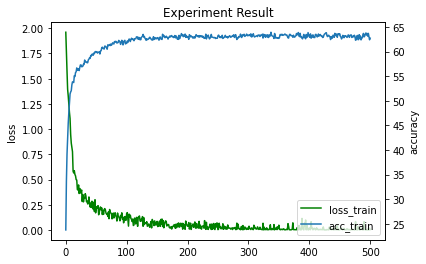

In [31]:
fig,ax1=plt.subplots()
ax2=ax1.twinx()
line1=ax1.plot(np.array(loss_train),color='g',label='loss_train')
line2=ax2.plot([i*1 for i in range(len(acc_train))],acc_train,label='acc_train')
lines=line1+line2
ax1.set_ylabel("loss")
ax2.set_ylabel("accuracy")
plt.xlabel('Epoch')
plt.title('Experiment Result')
plt.legend(lines,['loss_train','acc_train'])
plt.show()

cifar10 FedAvg Non-iid로 학습


In [31]:
device=torch.device('cuda')
FedAvg_model=Net().cuda()
criterion= nn.CrossEntropyLoss().to(device)
FedAvg_model.train()
epoch_loss = []

# Set optimizer for the local updates

optimizer = torch.optim.SGD(FedAvg_model.parameters(), lr=0.001,
                                momentum=0.9)
global_epoch=2001

In [32]:
weight_saved=FedAvg_model.state_dict()

In [33]:
C=0.1
num_clients=100
CIFAR_noniid_dataset=cifar_noniid(trainset, num_clients,class_per_user=2)
#CIFAR_iid_dataset=cifar_iid(trainset, num_clients)
loss_train = []
acc_train=[]

In [34]:
#low boundary 안에 있는 녀석들만 update했을 때
learning_rate=0.0007
for epoch in range(global_epoch):

    #m=max(int(C*num_clients),1)
    m=5
    print(f"This is global {epoch} epoch")
    selected_user=np.random.choice(range(num_clients),m,replace=False)
    first=1
    local_setting=[]
    for repeat in range(10):
        local_gradient=[]
        local_loss=[]
        local_cut=[]
        
        for idx,user in enumerate(selected_user):
            #print(f"client :{idx}")
            if first==1:
                #local_setting.append(LocalUpdate(lr=0.0007,local_epoch=50,device=device,batch_size=40,dataset=trainset, idxs=CIFAR_iid_dataset[user]))
                local_setting.append(LocalUpdate(lr=learning_rate,local_epoch=5,device=device,batch_size=40,dataset=trainset, idxs=CIFAR_noniid_dataset[user]))
                this_local_setting=local_setting[-1]
            else:
                this_local_setting=local_setting[idx]
            gradient,loss,cut=this_local_setting.train(net=copy.deepcopy(FedAvg_model).to(device),On=True)

            local_gradient.append(copy.deepcopy(gradient))
            #print(local_weight[0].keys())
            local_loss.append(copy.deepcopy(loss))
            local_cut.append(copy.deepcopy(cut))
        #print("Local_gradient")
        #print(local_gradient)
        first=0
        FedAvg_gradient=copy.deepcopy(local_gradient[0])
        for i in range(len(FedAvg_gradient)):
            FedAvg_gradient[i]*=local_cut[0]
        #print(local_gradient)
        #for key in FedAvg_weight.keys():
        for i in range(1,len(local_gradient)):
            FedAvg_gradient=list_add(FedAvg_gradient,local_gradient[i],local_cut[i])
            #print(i)
            #print(FedAvg_gradient[0])
        #print("FedAvg_gradient")
        #print(FedAvg_gradient)
        temp=FedAvg_model.state_dict()
        for idx,key in enumerate(temp.keys()):
            #print(key)
            #print(temp[key].size())
            #print(FedAvg_gradient[idx].size())
            #print(torch.sign(FedAvg_gradient[idx]))
            #print(torch.sign(FedAvg_gradient[idx])*learning_rate)
            temp[key]+=-learning_rate*torch.sign(FedAvg_gradient[idx])
            #print(temp[key])
        FedAvg_model.load_state_dict(temp)
    first=1
    loss_avg = sum(local_loss) / len(local_loss)
    print(' Average loss {:.3f}'.format( loss_avg))
    loss_train.append(loss_avg)
    if epoch%1==0:
        for j in range(1):
            FedAvg_model.eval()         
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = FedAvg_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %f %%' % (
                100 * correct / float(total)))
        acc_train.append(100 * correct / float(total))
 
    FedAvg_model.train()

This is global 0 epoch


/home/sonic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


 Average loss 0.786
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1 epoch
 Average loss 0.752
Accuracy of the network on the 10000 test images: 15.330000 %
This is global 2 epoch
 Average loss 0.557
Accuracy of the network on the 10000 test images: 18.990000 %
This is global 3 epoch
 Average loss 0.475
Accuracy of the network on the 10000 test images: 18.610000 %
This is global 4 epoch
 Average loss 0.461
Accuracy of the network on the 10000 test images: 14.450000 %
This is global 5 epoch
 Average loss 0.398
Accuracy of the network on the 10000 test images: 17.200000 %
This is global 6 epoch
 Average loss 0.450
Accuracy of the network on the 10000 test images: 21.150000 %
This is global 7 epoch
 Average loss 0.367
Accuracy of the network on the 10000 test images: 19.790000 %
This is global 8 epoch
 Average loss 0.408
Accuracy of the network on the 10000 test images: 20.640000 %
This is global 9 epoch
 Average loss 0.335
Accuracy of the network on the 1000

 Average loss 0.103
Accuracy of the network on the 10000 test images: 30.000000 %
This is global 79 epoch
 Average loss 0.066
Accuracy of the network on the 10000 test images: 35.020000 %
This is global 80 epoch
 Average loss 0.071
Accuracy of the network on the 10000 test images: 30.270000 %
This is global 81 epoch
 Average loss 0.104
Accuracy of the network on the 10000 test images: 33.590000 %
This is global 82 epoch
 Average loss 0.082
Accuracy of the network on the 10000 test images: 36.570000 %
This is global 83 epoch
 Average loss 0.026
Accuracy of the network on the 10000 test images: 45.080000 %
This is global 84 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 38.870000 %
This is global 85 epoch
 Average loss 0.062
Accuracy of the network on the 10000 test images: 38.380000 %
This is global 86 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 38.500000 %
This is global 87 epoch
 Average loss 0.048
Accuracy of the network on

 Average loss 0.093
Accuracy of the network on the 10000 test images: 42.120000 %
This is global 156 epoch
 Average loss 0.071
Accuracy of the network on the 10000 test images: 44.120000 %
This is global 157 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 44.110000 %
This is global 158 epoch
 Average loss 0.025
Accuracy of the network on the 10000 test images: 46.700000 %
This is global 159 epoch
 Average loss 0.082
Accuracy of the network on the 10000 test images: 43.590000 %
This is global 160 epoch
 Average loss 0.045
Accuracy of the network on the 10000 test images: 44.850000 %
This is global 161 epoch
 Average loss 0.051
Accuracy of the network on the 10000 test images: 43.000000 %
This is global 162 epoch
 Average loss 0.065
Accuracy of the network on the 10000 test images: 43.130000 %
This is global 163 epoch
 Average loss 0.095
Accuracy of the network on the 10000 test images: 44.370000 %
This is global 164 epoch
 Average loss 0.037
Accuracy of the n

 Average loss 0.031
Accuracy of the network on the 10000 test images: 45.340000 %
This is global 233 epoch
 Average loss 0.067
Accuracy of the network on the 10000 test images: 40.190000 %
This is global 234 epoch
 Average loss 0.024
Accuracy of the network on the 10000 test images: 44.730000 %
This is global 235 epoch
 Average loss 0.053
Accuracy of the network on the 10000 test images: 45.410000 %
This is global 236 epoch
 Average loss 0.029
Accuracy of the network on the 10000 test images: 44.500000 %
This is global 237 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 37.450000 %
This is global 238 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 35.110000 %
This is global 239 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 43.500000 %
This is global 240 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 44.640000 %
This is global 241 epoch
 Average loss 0.044
Accuracy of the n

 Average loss 0.016
Accuracy of the network on the 10000 test images: 45.260000 %
This is global 310 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 46.190000 %
This is global 311 epoch
 Average loss 0.064
Accuracy of the network on the 10000 test images: 44.570000 %
This is global 312 epoch
 Average loss 0.011
Accuracy of the network on the 10000 test images: 46.180000 %
This is global 313 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 47.110000 %
This is global 314 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 47.600000 %
This is global 315 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 47.690000 %
This is global 316 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 48.130000 %
This is global 317 epoch
 Average loss 0.027
Accuracy of the network on the 10000 test images: 50.000000 %
This is global 318 epoch
 Average loss 0.044
Accuracy of the n

 Average loss 0.046
Accuracy of the network on the 10000 test images: 46.050000 %
This is global 387 epoch
 Average loss 0.015
Accuracy of the network on the 10000 test images: 45.150000 %
This is global 388 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 45.580000 %
This is global 389 epoch
 Average loss 0.014
Accuracy of the network on the 10000 test images: 49.020000 %
This is global 390 epoch
 Average loss 0.070
Accuracy of the network on the 10000 test images: 49.170000 %
This is global 391 epoch
 Average loss 0.016
Accuracy of the network on the 10000 test images: 45.580000 %
This is global 392 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 48.720000 %
This is global 393 epoch
 Average loss 0.022
Accuracy of the network on the 10000 test images: 45.940000 %
This is global 394 epoch
 Average loss 0.033
Accuracy of the network on the 10000 test images: 48.120000 %
This is global 395 epoch
 Average loss 0.014
Accuracy of the n

 Average loss 0.047
Accuracy of the network on the 10000 test images: 47.900000 %
This is global 464 epoch
 Average loss 0.015
Accuracy of the network on the 10000 test images: 45.920000 %
This is global 465 epoch
 Average loss 0.019
Accuracy of the network on the 10000 test images: 49.790000 %
This is global 466 epoch
 Average loss 0.013
Accuracy of the network on the 10000 test images: 49.780000 %
This is global 467 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 49.320000 %
This is global 468 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 50.860000 %
This is global 469 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 49.590000 %
This is global 470 epoch
 Average loss 0.015
Accuracy of the network on the 10000 test images: 50.630000 %
This is global 471 epoch
 Average loss 0.011
Accuracy of the network on the 10000 test images: 48.950000 %
This is global 472 epoch
 Average loss 0.013
Accuracy of the n

 Average loss 0.012
Accuracy of the network on the 10000 test images: 42.300000 %
This is global 541 epoch
 Average loss 0.015
Accuracy of the network on the 10000 test images: 47.720000 %
This is global 542 epoch
 Average loss 0.014
Accuracy of the network on the 10000 test images: 49.880000 %
This is global 543 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 50.820000 %
This is global 544 epoch
 Average loss 0.016
Accuracy of the network on the 10000 test images: 49.150000 %
This is global 545 epoch
 Average loss 0.016
Accuracy of the network on the 10000 test images: 50.110000 %
This is global 546 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 49.830000 %
This is global 547 epoch
 Average loss 0.009
Accuracy of the network on the 10000 test images: 50.590000 %
This is global 548 epoch
 Average loss 0.046
Accuracy of the network on the 10000 test images: 46.460000 %
This is global 549 epoch
 Average loss 0.031
Accuracy of the n

KeyboardInterrupt: 

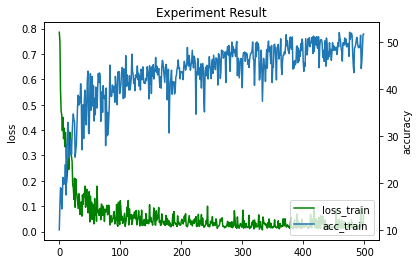

In [35]:
fig,ax1=plt.subplots()
ax2=ax1.twinx()
line1=ax1.plot(np.array(loss_train[:500]),color='g',label='loss_train')
line2=ax2.plot([i*1 for i in range(len(acc_train[:500]))],acc_train[:500],label='acc_train')
lines=line1+line2
ax1.set_ylabel("loss")
ax2.set_ylabel("accuracy")
plt.xlabel('Epoch')
plt.title('Experiment Result')
plt.legend(lines,['loss_train','acc_train'])
plt.show()

In [34]:
C=0.1
num_clients=100
CIFAR_noniid_dataset=cifar_noniid(trainset, num_clients)
#CIFAR_iid_dataset=cifar_iid(trainset, num_clients)
loss_train = []
acc_train=[]

In [35]:
#low boundary 안에 있는 녀석들만 update했을 때
learning_rate=0.0007
for epoch in range(global_epoch):

    #m=max(int(C*num_clients),1)
    m=5
    print(f"This is global {epoch} epoch")
    selected_user=np.random.choice(range(num_clients),m,replace=False)
    first=1
    local_setting=[]
    for repeat in range(10):
        local_gradient=[]
        local_loss=[]
        local_cut=[]
        
        for idx,user in enumerate(selected_user):
            #print(f"client :{idx}")
            if first==1:
                #local_setting.append(LocalUpdate(lr=0.0007,local_epoch=50,device=device,batch_size=40,dataset=trainset, idxs=CIFAR_iid_dataset[user]))
                local_setting.append(LocalUpdate(lr=learning_rate,local_epoch=5,device=device,batch_size=40,dataset=trainset, idxs=CIFAR_noniid_dataset[user]))
                this_local_setting=local_setting[-1]
            else:
                this_local_setting=local_setting[idx]
            gradient,loss,cut=this_local_setting.train(net=copy.deepcopy(FedAvg_model).to(device),On=True)

            local_gradient.append(copy.deepcopy(gradient))
            #print(local_weight[0].keys())
            local_loss.append(copy.deepcopy(loss))
            local_cut.append(copy.deepcopy(cut))
        #print("Local_gradient")
        #print(local_gradient)
        first=0
        FedAvg_gradient=copy.deepcopy(local_gradient[0])
        for i in range(len(FedAvg_gradient)):
            FedAvg_gradient[i]*=local_cut[0]
        #print(local_gradient)
        #for key in FedAvg_weight.keys():
        for i in range(1,len(local_gradient)):
            FedAvg_gradient=list_add(FedAvg_gradient,local_gradient[i],local_cut[i])
            #print(i)
            #print(FedAvg_gradient[0])
        #print("FedAvg_gradient")
        #print(FedAvg_gradient)
        temp=FedAvg_model.state_dict()
        for idx,key in enumerate(temp.keys()):
            #print(key)
            #print(temp[key].size())
            #print(FedAvg_gradient[idx].size())
            #print(torch.sign(FedAvg_gradient[idx]))
            #print(torch.sign(FedAvg_gradient[idx])*learning_rate)
            temp[key]+=-learning_rate*torch.sign(FedAvg_gradient[idx])
            #print(temp[key])
        FedAvg_model.load_state_dict(temp)
    first=1
    loss_avg = sum(local_loss) / len(local_loss)
    print(' Average loss {:.3f}'.format( loss_avg))
    loss_train.append(loss_avg)
    if epoch%1==0:
        for j in range(1):
            FedAvg_model.eval()         
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = FedAvg_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %f %%' % (
                100 * correct / float(total)))
        acc_train.append(100 * correct / float(total))
 
    FedAvg_model.train()

This is global 0 epoch


/home/sonic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


 Average loss 0.029
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1 epoch
 Average loss 0.021
Accuracy of the network on the 10000 test images: 10.010000 %
This is global 2 epoch
 Average loss 0.027
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3 epoch
 Average loss 0.029
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4 epoch
 Average loss 0.035
Accuracy of the network on the 10000 test images: 9.460000 %
This is global 5 epoch
 Average loss 0.030
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 6 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 7 epoch
 Average loss 0.033
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 8 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 9 epoch
 Average loss 0.028
Accuracy of the network on the 10000

 Average loss 0.036
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 79 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 10.440000 %
This is global 80 epoch
 Average loss 0.027
Accuracy of the network on the 10000 test images: 10.340000 %
This is global 81 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 82 epoch
 Average loss 0.030
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 83 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 84 epoch
 Average loss 0.031
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 85 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 9.960000 %
This is global 86 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 87 epoch
 Average loss 0.035
Accuracy of the network on 

 Average loss 0.034
Accuracy of the network on the 10000 test images: 10.120000 %
This is global 156 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 10.880000 %
This is global 157 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 10.370000 %
This is global 158 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 11.000000 %
This is global 159 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 11.210000 %
This is global 160 epoch
 Average loss 0.045
Accuracy of the network on the 10000 test images: 9.680000 %
This is global 161 epoch
 Average loss 0.055
Accuracy of the network on the 10000 test images: 9.780000 %
This is global 162 epoch
 Average loss 0.030
Accuracy of the network on the 10000 test images: 9.650000 %
This is global 163 epoch
 Average loss 0.035
Accuracy of the network on the 10000 test images: 11.060000 %
This is global 164 epoch
 Average loss 0.032
Accuracy of the netw

 Average loss 0.071
Accuracy of the network on the 10000 test images: 9.730000 %
This is global 233 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 9.160000 %
This is global 234 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 9.370000 %
This is global 235 epoch
 Average loss 0.055
Accuracy of the network on the 10000 test images: 9.080000 %
This is global 236 epoch
 Average loss 0.058
Accuracy of the network on the 10000 test images: 9.980000 %
This is global 237 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 9.720000 %
This is global 238 epoch
 Average loss 0.032
Accuracy of the network on the 10000 test images: 10.280000 %
This is global 239 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 10.570000 %
This is global 240 epoch
 Average loss 0.052
Accuracy of the network on the 10000 test images: 10.490000 %
This is global 241 epoch
 Average loss 0.047
Accuracy of the network

 Average loss 0.039
Accuracy of the network on the 10000 test images: 9.840000 %
This is global 310 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 10.230000 %
This is global 311 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 9.940000 %
This is global 312 epoch
 Average loss 0.035
Accuracy of the network on the 10000 test images: 10.080000 %
This is global 313 epoch
 Average loss 0.048
Accuracy of the network on the 10000 test images: 9.400000 %
This is global 314 epoch
 Average loss 0.046
Accuracy of the network on the 10000 test images: 10.070000 %
This is global 315 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 8.720000 %
This is global 316 epoch
 Average loss 0.029
Accuracy of the network on the 10000 test images: 10.010000 %
This is global 317 epoch
 Average loss 0.043
Accuracy of the network on the 10000 test images: 10.710000 %
This is global 318 epoch
 Average loss 0.033
Accuracy of the netwo

 Average loss 0.035
Accuracy of the network on the 10000 test images: 10.150000 %
This is global 387 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 10.170000 %
This is global 388 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 10.230000 %
This is global 389 epoch
 Average loss 0.044
Accuracy of the network on the 10000 test images: 10.060000 %
This is global 390 epoch
 Average loss 0.045
Accuracy of the network on the 10000 test images: 9.960000 %
This is global 391 epoch
 Average loss 0.392
Accuracy of the network on the 10000 test images: 10.060000 %
This is global 392 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 10.040000 %
This is global 393 epoch
 Average loss 0.063
Accuracy of the network on the 10000 test images: 10.050000 %
This is global 394 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 10.140000 %
This is global 395 epoch
 Average loss 0.043
Accuracy of the ne

 Average loss 0.057
Accuracy of the network on the 10000 test images: 10.170000 %
This is global 464 epoch
 Average loss 0.047
Accuracy of the network on the 10000 test images: 10.160000 %
This is global 465 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 10.310000 %
This is global 466 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 10.170000 %
This is global 467 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 10.070000 %
This is global 468 epoch
 Average loss 0.046
Accuracy of the network on the 10000 test images: 10.080000 %
This is global 469 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 10.190000 %
This is global 470 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 10.120000 %
This is global 471 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 10.060000 %
This is global 472 epoch
 Average loss 0.034
Accuracy of the n

 Average loss 0.040
Accuracy of the network on the 10000 test images: 10.500000 %
This is global 541 epoch
 Average loss 0.043
Accuracy of the network on the 10000 test images: 10.390000 %
This is global 542 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 10.650000 %
This is global 543 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 10.740000 %
This is global 544 epoch
 Average loss 0.045
Accuracy of the network on the 10000 test images: 10.420000 %
This is global 545 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 10.320000 %
This is global 546 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 10.160000 %
This is global 547 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 10.470000 %
This is global 548 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 10.230000 %
This is global 549 epoch
 Average loss 0.038
Accuracy of the n

 Average loss 0.042
Accuracy of the network on the 10000 test images: 10.240000 %
This is global 618 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 10.010000 %
This is global 619 epoch
 Average loss 0.402
Accuracy of the network on the 10000 test images: 10.010000 %
This is global 620 epoch
 Average loss 0.047
Accuracy of the network on the 10000 test images: 10.070000 %
This is global 621 epoch
 Average loss 0.045
Accuracy of the network on the 10000 test images: 10.030000 %
This is global 622 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 10.070000 %
This is global 623 epoch
 Average loss 0.053
Accuracy of the network on the 10000 test images: 10.060000 %
This is global 624 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 10.050000 %
This is global 625 epoch
 Average loss 0.042
Accuracy of the network on the 10000 test images: 9.920000 %
This is global 626 epoch
 Average loss 0.033
Accuracy of the ne

 Average loss 0.053
Accuracy of the network on the 10000 test images: 10.330000 %
This is global 695 epoch
 Average loss 0.035
Accuracy of the network on the 10000 test images: 10.170000 %
This is global 696 epoch
 Average loss 0.043
Accuracy of the network on the 10000 test images: 10.150000 %
This is global 697 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 10.470000 %
This is global 698 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 10.170000 %
This is global 699 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 10.160000 %
This is global 700 epoch
 Average loss 0.031
Accuracy of the network on the 10000 test images: 10.060000 %
This is global 701 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 10.040000 %
This is global 702 epoch
 Average loss 0.044
Accuracy of the network on the 10000 test images: 10.030000 %
This is global 703 epoch
 Average loss 0.037
Accuracy of the n

 Average loss 0.043
Accuracy of the network on the 10000 test images: 10.410000 %
This is global 772 epoch
 Average loss 0.049
Accuracy of the network on the 10000 test images: 10.180000 %
This is global 773 epoch
 Average loss 0.045
Accuracy of the network on the 10000 test images: 10.390000 %
This is global 774 epoch
 Average loss 0.044
Accuracy of the network on the 10000 test images: 10.300000 %
This is global 775 epoch
 Average loss 0.035
Accuracy of the network on the 10000 test images: 10.320000 %
This is global 776 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 10.120000 %
This is global 777 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 10.470000 %
This is global 778 epoch
 Average loss 0.035
Accuracy of the network on the 10000 test images: 10.560000 %
This is global 779 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 10.110000 %
This is global 780 epoch
 Average loss 0.032
Accuracy of the n

 Average loss 0.060
Accuracy of the network on the 10000 test images: 10.660000 %
This is global 849 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 10.270000 %
This is global 850 epoch
 Average loss 0.055
Accuracy of the network on the 10000 test images: 10.080000 %
This is global 851 epoch
 Average loss 0.046
Accuracy of the network on the 10000 test images: 10.200000 %
This is global 852 epoch
 Average loss 0.094
Accuracy of the network on the 10000 test images: 10.030000 %
This is global 853 epoch
 Average loss 0.030
Accuracy of the network on the 10000 test images: 10.020000 %
This is global 854 epoch
 Average loss 0.872
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 855 epoch
 Average loss 0.049
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 856 epoch
 Average loss 0.101
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 857 epoch
 Average loss 0.037
Accuracy of the n

 Average loss 0.079
Accuracy of the network on the 10000 test images: 10.050000 %
This is global 926 epoch
 Average loss 0.035
Accuracy of the network on the 10000 test images: 10.420000 %
This is global 927 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 10.400000 %
This is global 928 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 10.280000 %
This is global 929 epoch
 Average loss 0.057
Accuracy of the network on the 10000 test images: 10.200000 %
This is global 930 epoch
 Average loss 0.045
Accuracy of the network on the 10000 test images: 10.260000 %
This is global 931 epoch
 Average loss 0.046
Accuracy of the network on the 10000 test images: 10.080000 %
This is global 932 epoch
 Average loss 0.053
Accuracy of the network on the 10000 test images: 10.060000 %
This is global 933 epoch
 Average loss 0.045
Accuracy of the network on the 10000 test images: 10.240000 %
This is global 934 epoch
 Average loss 0.046
Accuracy of the n

 Average loss 0.055
Accuracy of the network on the 10000 test images: 10.020000 %
This is global 1003 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 10.380000 %
This is global 1004 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 10.240000 %
This is global 1005 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1006 epoch
 Average loss 0.060
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1007 epoch
 Average loss 0.049
Accuracy of the network on the 10000 test images: 10.440000 %
This is global 1008 epoch
 Average loss 0.086
Accuracy of the network on the 10000 test images: 10.370000 %
This is global 1009 epoch
 Average loss 0.043
Accuracy of the network on the 10000 test images: 10.310000 %
This is global 1010 epoch
 Average loss 0.050
Accuracy of the network on the 10000 test images: 10.260000 %
This is global 1011 epoch
 Average loss 0.039
Accuracy

 Average loss 0.038
Accuracy of the network on the 10000 test images: 10.080000 %
This is global 1079 epoch
 Average loss 0.029
Accuracy of the network on the 10000 test images: 10.010000 %
This is global 1080 epoch
 Average loss 0.043
Accuracy of the network on the 10000 test images: 9.990000 %
This is global 1081 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 9.950000 %
This is global 1082 epoch
 Average loss 0.048
Accuracy of the network on the 10000 test images: 9.810000 %
This is global 1083 epoch
 Average loss 0.030
Accuracy of the network on the 10000 test images: 9.840000 %
This is global 1084 epoch
 Average loss 0.084
Accuracy of the network on the 10000 test images: 9.640000 %
This is global 1085 epoch
 Average loss 0.032
Accuracy of the network on the 10000 test images: 9.690000 %
This is global 1086 epoch
 Average loss 0.035
Accuracy of the network on the 10000 test images: 10.300000 %
This is global 1087 epoch
 Average loss 0.046
Accuracy of th

Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1155 epoch
 Average loss 0.042
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1156 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 10.030000 %
This is global 1157 epoch
 Average loss 0.033
Accuracy of the network on the 10000 test images: 9.500000 %
This is global 1158 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 10.360000 %
This is global 1159 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 9.650000 %
This is global 1160 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 9.330000 %
This is global 1161 epoch
 Average loss 0.042
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1162 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1163 epoch
 Average loss 0.036
Accuracy of the network on the 

 Average loss 0.029
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1232 epoch
 Average loss 0.051
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1233 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1234 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1235 epoch
 Average loss 0.051
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1236 epoch
 Average loss 0.048
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1237 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 9.910000 %
This is global 1238 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 10.010000 %
This is global 1239 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 9.910000 %
This is global 1240 epoch
 Average loss 0.068
Accuracy o

 Average loss 0.043
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1309 epoch
 Average loss 0.044
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1310 epoch
 Average loss 0.082
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1311 epoch
 Average loss 0.033
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1312 epoch
 Average loss 0.043
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1313 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1314 epoch
 Average loss 0.048
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1315 epoch
 Average loss 0.046
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1316 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1317 epoch
 Average loss 0.042
Accuracy

 Average loss 0.037
Accuracy of the network on the 10000 test images: 10.120000 %
This is global 1385 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 12.270000 %
This is global 1386 epoch
 Average loss 0.035
Accuracy of the network on the 10000 test images: 10.370000 %
This is global 1387 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 10.150000 %
This is global 1388 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 10.030000 %
This is global 1389 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 10.070000 %
This is global 1390 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 10.080000 %
This is global 1391 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 10.110000 %
This is global 1392 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 10.190000 %
This is global 1393 epoch
 Average loss 0.033
Accuracy

Accuracy of the network on the 10000 test images: 10.170000 %
This is global 1461 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 10.120000 %
This is global 1462 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 9.950000 %
This is global 1463 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 9.900000 %
This is global 1464 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 9.910000 %
This is global 1465 epoch
 Average loss 0.108
Accuracy of the network on the 10000 test images: 10.100000 %
This is global 1466 epoch
 Average loss 0.046
Accuracy of the network on the 10000 test images: 10.070000 %
This is global 1467 epoch
 Average loss 0.188
Accuracy of the network on the 10000 test images: 9.920000 %
This is global 1468 epoch
 Average loss 0.035
Accuracy of the network on the 10000 test images: 9.790000 %
This is global 1469 epoch
 Average loss 0.036
Accuracy of the network on the 10

 Average loss 0.039
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1538 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1539 epoch
 Average loss 0.066
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1540 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 9.970000 %
This is global 1541 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 10.020000 %
This is global 1542 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 10.030000 %
This is global 1543 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 9.990000 %
This is global 1544 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 9.660000 %
This is global 1545 epoch
 Average loss 0.033
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1546 epoch
 Average loss 0.032
Accuracy of

 Average loss 0.026
Accuracy of the network on the 10000 test images: 10.150000 %
This is global 1614 epoch
 Average loss 0.045
Accuracy of the network on the 10000 test images: 11.070000 %
This is global 1615 epoch
 Average loss 0.056
Accuracy of the network on the 10000 test images: 10.010000 %
This is global 1616 epoch
 Average loss 0.030
Accuracy of the network on the 10000 test images: 10.470000 %
This is global 1617 epoch
 Average loss 0.049
Accuracy of the network on the 10000 test images: 10.130000 %
This is global 1618 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 10.110000 %
This is global 1619 epoch
 Average loss 0.046
Accuracy of the network on the 10000 test images: 10.210000 %
This is global 1620 epoch
 Average loss 0.045
Accuracy of the network on the 10000 test images: 10.360000 %
This is global 1621 epoch
 Average loss 0.043
Accuracy of the network on the 10000 test images: 10.070000 %
This is global 1622 epoch
 Average loss 0.040
Accuracy

 Average loss 0.037
Accuracy of the network on the 10000 test images: 11.120000 %
This is global 1690 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 11.140000 %
This is global 1691 epoch
 Average loss 0.033
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1692 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 12.900000 %
This is global 1693 epoch
 Average loss 0.035
Accuracy of the network on the 10000 test images: 13.440000 %
This is global 1694 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 12.650000 %
This is global 1695 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 13.340000 %
This is global 1696 epoch
 Average loss 0.035
Accuracy of the network on the 10000 test images: 12.630000 %
This is global 1697 epoch
 Average loss 0.043
Accuracy of the network on the 10000 test images: 10.170000 %
This is global 1698 epoch
 Average loss 0.040
Accuracy

 Average loss 0.038
Accuracy of the network on the 10000 test images: 10.360000 %
This is global 1766 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 10.410000 %
This is global 1767 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 10.250000 %
This is global 1768 epoch
 Average loss 0.024
Accuracy of the network on the 10000 test images: 10.080000 %
This is global 1769 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 10.120000 %
This is global 1770 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 10.150000 %
This is global 1771 epoch
 Average loss 0.035
Accuracy of the network on the 10000 test images: 10.090000 %
This is global 1772 epoch
 Average loss 0.048
Accuracy of the network on the 10000 test images: 10.070000 %
This is global 1773 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 10.180000 %
This is global 1774 epoch
 Average loss 0.049
Accuracy

 Average loss 0.054
Accuracy of the network on the 10000 test images: 10.150000 %
This is global 1842 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 10.060000 %
This is global 1843 epoch
 Average loss 0.050
Accuracy of the network on the 10000 test images: 10.240000 %
This is global 1844 epoch
 Average loss 0.045
Accuracy of the network on the 10000 test images: 10.040000 %
This is global 1845 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 10.280000 %
This is global 1846 epoch
 Average loss 0.043
Accuracy of the network on the 10000 test images: 10.140000 %
This is global 1847 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 10.070000 %
This is global 1848 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 10.080000 %
This is global 1849 epoch
 Average loss 0.046
Accuracy of the network on the 10000 test images: 10.250000 %
This is global 1850 epoch
 Average loss 0.040
Accuracy

 Average loss 0.090
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1918 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1919 epoch
 Average loss 0.071
Accuracy of the network on the 10000 test images: 10.100000 %
This is global 1920 epoch
 Average loss 0.042
Accuracy of the network on the 10000 test images: 10.050000 %
This is global 1921 epoch
 Average loss 0.035
Accuracy of the network on the 10000 test images: 10.200000 %
This is global 1922 epoch
 Average loss 0.027
Accuracy of the network on the 10000 test images: 10.060000 %
This is global 1923 epoch
 Average loss 0.054
Accuracy of the network on the 10000 test images: 10.290000 %
This is global 1924 epoch
 Average loss 0.061
Accuracy of the network on the 10000 test images: 10.080000 %
This is global 1925 epoch
 Average loss 0.045
Accuracy of the network on the 10000 test images: 10.110000 %
This is global 1926 epoch
 Average loss 0.032
Accuracy

 Average loss 0.043
Accuracy of the network on the 10000 test images: 10.040000 %
This is global 1994 epoch
 Average loss 0.049
Accuracy of the network on the 10000 test images: 10.020000 %
This is global 1995 epoch
 Average loss 0.052
Accuracy of the network on the 10000 test images: 10.020000 %
This is global 1996 epoch
 Average loss 0.054
Accuracy of the network on the 10000 test images: 10.010000 %
This is global 1997 epoch
 Average loss 0.050
Accuracy of the network on the 10000 test images: 10.040000 %
This is global 1998 epoch
 Average loss 0.054
Accuracy of the network on the 10000 test images: 10.030000 %
This is global 1999 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 10.030000 %
This is global 2000 epoch
 Average loss 0.054
Accuracy of the network on the 10000 test images: 10.030000 %


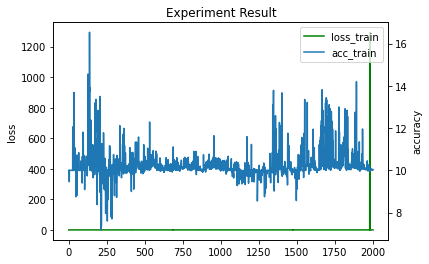

In [36]:
fig,ax1=plt.subplots()
ax2=ax1.twinx()
line1=ax1.plot(np.array(loss_train),color='g',label='loss_train')
line2=ax2.plot([i*1 for i in range(len(acc_train))],acc_train,label='acc_train')
lines=line1+line2
ax1.set_ylabel("loss")
ax2.set_ylabel("accuracy")
plt.xlabel('Epoch')
plt.title('Experiment Result')
plt.legend(lines,['loss_train','acc_train'])
plt.show()